# Recency,Frequency and Monetary value analysis

### Importing libraries

In [1]:
import pandas as pd 
import datetime as dt 
import numpy as np
import matplotlib.pyplot as plt

### Loading data

In [2]:
df=pd.read_csv('C:/Users/ADMIN/OneDrive/Desktop/Mike/mydata/rfm_data.csv')
df.head(5)

,CustomerID,PurchaseDate,TransactionAmount,ProductInformation,OrderID,Location
0,8814,4/11/2023,943.31,Product C,890075,Tokyo
1,2188,4/11/2023,463.70,Product A,176819,London
2,4608,4/11/2023,80.28,Product A,340062,New York
3,2559,4/11/2023,221.29,Product A,239145,London
4,9482,4/11/2023,739.56,Product A,194545,Paris


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   CustomerID          1000 non-null   int64  
 1   PurchaseDate        1000 non-null   object 
 2   TransactionAmount   1000 non-null   float64
 3   ProductInformation  1000 non-null   object 
 4   OrderID             1000 non-null   int64  
 5   Location            1000 non-null   object 
dtypes: float64(1), int64(2), object(3)
memory usage: 47.0+ KB


In [4]:
### changing the PurchaseDate to datetime 
df['PurchaseDate']=pd.to_datetime(df['PurchaseDate'])

In [5]:
df.shape

(1000, 6)

In [6]:
df.isnull().sum()

CustomerID            0
PurchaseDate          0
TransactionAmount     0
ProductInformation    0
OrderID               0
Location              0
dtype: int64

### Calculating Recency 

In [7]:
df_recency= df.groupby(by='CustomerID',as_index=False)['PurchaseDate'].max()
df_recency.columns= ['Customer','PurchaseDate']
recent_date=df_recency['PurchaseDate'].max()
df_recency['Recency']=df_recency['PurchaseDate'].apply(lambda x :(recent_date-x).days)
df_recency.head(5)

,Customer,PurchaseDate,Recency
0,1011,2023-05-08,33
1,1025,2023-05-20,21
2,1029,2023-06-10,0
3,1046,2023-04-28,43
4,1049,2023-05-28,13


### Calculating Frequency

In [8]:
df_frequency=df.drop_duplicates().groupby(by=['CustomerID'],as_index=False)['PurchaseDate'].count()
df_frequency.columns=['Customer','Frequency']
df_frequency.head(5)

,Customer,Frequency
0,1011,2
1,1025,1
2,1029,1
3,1046,1
4,1049,1


### Calculating Monetary Value

In [12]:
df_monetary=df.groupby(by=['CustomerID'],as_index=False)['TransactionAmount'].sum()
df_monetary.columns=['Customer','Monetary']
df_monetary.head(5)

,Customer,Monetary
0,1011,1129.02
1,1025,359.29
2,1029,704.99
3,1046,859.82
4,1049,225.72


### Merging all columns

In [13]:
df_RF=df_recency.merge(df_frequency,on='Customer')
df_RFM=df_RF.merge(df_monetary,on='Customer'). drop(columns='PurchaseDate')
df_RFM.head(5)


,Customer,Recency,Frequency,Monetary
0,1011,33,2,1129.02
1,1025,21,1,359.29
2,1029,0,1,704.99
3,1046,43,1,859.82
4,1049,13,1,225.72


### Ranking Customer’s based upon their recency, frequency, and monetary score

In [14]:
df_RFM['R_rank'] = df_RFM['Recency'].rank(ascending=False)
df_RFM['F_rank'] = df_RFM['Frequency'].rank(ascending=True)
df_RFM['M_rank'] = df_RFM['Monetary'].rank(ascending=True)
 
# Normalizing the rank of the customers
df_RFM['R_rank_norm'] = (df_RFM['R_rank']/df_RFM['R_rank'].max())*100
df_RFM['F_rank_norm'] = (df_RFM['F_rank']/df_RFM['F_rank'].max())*100
df_RFM['M_rank_norm'] = (df_RFM['F_rank']/df_RFM['M_rank'].max())*100
 
df_RFM.drop(columns=['R_rank', 'F_rank', 'M_rank'], inplace=True)
 
df_RFM.head(5)


,Customer,Recency,Frequency,Monetary,R_rank_norm,F_rank_norm,M_rank_norm
0,1011,33,2,1129.02,47.331910,97.301587,97.198732
1,1025,21,1,359.29,64.727855,47.407407,47.357294
2,1029,0,1,704.99,100.000000,47.407407,47.357294
3,1046,43,1,859.82,27.908218,47.407407,47.357294
4,1049,13,1,225.72,78.762006,47.407407,47.357294


### Calculating RFM score

In [15]:
df_RFM['RFM_Score'] = 0.15*df_RFM['R_rank_norm']+0.28 * \
    df_RFM['F_rank_norm']+0.57*df_RFM['M_rank_norm']
df_RFM['RFM_Score'] *= 0.05
df_RFM=df_RFM.round(2)
df_RFM[['Customer', 'RFM_Score']].head(5)

,Customer,RFM_Score
0,1011,4.49
1,1025,2.50
2,1029,2.76
3,1046,2.22
4,1049,2.60


### Rating Customer based upon the RFM score

In [16]:
# rfm score >4.5 : Top Customer
# 4.5 > rfm score > 4 : High Value Customer
# 4>rfm score >3 : Medium value customer
# 3>rfm score>1.6 : Low-value customer
# rfm score<1.6 :Lost Customer

In [17]:
df_RFM["Customer_segment"] = np.where(df_RFM['RFM_Score'] >
                                      4.5, "Top Customers", 
                                      (np.where(
                                        df_RFM['RFM_Score'] > 4,
                                        "High value Customer",
                                        (np.where(
   df_RFM['RFM_Score'] > 3,
                             "Medium Value Customer",
                             np.where(df_RFM['RFM_Score'] > 1.6, 
                            'Low Value Customers', 'Lost Customers'))))))
df_RFM[['Customer', 'RFM_Score', 'Customer_segment']].head(5)

,Customer,RFM_Score,Customer_segment
0,1011,4.49,High value Customer
1,1025,2.50,Low Value Customers
2,1029,2.76,Low Value Customers
3,1046,2.22,Low Value Customers
4,1049,2.60,Low Value Customers


### Visualizing the customer segments

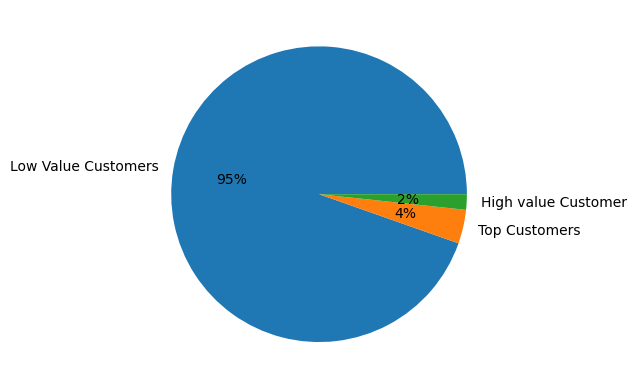

In [18]:
plt.pie(df_RFM.Customer_segment.value_counts(),
        labels=df_RFM.Customer_segment.value_counts().index,
        autopct='%.0f%%')
plt.show()